# Optimization in Machine Learning: Gradient Descent Variants & Saddle Points

This notebook investigates two central topics in modern optimization for machine learning:

1. **Gradient Descent Variants** — How vanilla GD, Momentum, and Adam differ in convergence speed and trajectory on a challenging non-convex landscape.
2. **Saddle Points in High Dimensions** — Why saddle points are a fundamental obstacle in deep learning and how noise helps escape them.

---

## Part 1: Gradient Descent Variants

### Background

Gradient descent and its variants are the backbone of training almost every machine learning model. All of them update parameters by moving in the direction of the negative gradient, but they differ in *how* that step is computed.

#### Vanilla Gradient Descent (GD)

The simplest update rule:
$$\theta_{t+1} = \theta_t - \eta \nabla L(\theta_t)$$

where $\eta$ is the learning rate and $\nabla L$ is the gradient of the loss. GD moves directly downhill at every step. Its weakness: it oscillates on ill-conditioned surfaces and converges slowly in narrow valleys.

#### Momentum

Inspired by physics — a ball rolling down a hill accumulates velocity:
$$v_{t+1} = \beta v_t + \nabla L(\theta_t), \qquad \theta_{t+1} = \theta_t - \eta v_{t+1}$$

The momentum term $\beta$ (typically 0.9) smooths updates by accumulating a moving average of past gradients. This dampens oscillations and accelerates progress along consistent directions.

#### Adam (Adaptive Moment Estimation)

Adam maintains *two* running averages — the first moment (mean) and second moment (uncentred variance) of the gradients:
$$m_t = \beta_1 m_{t-1} + (1-\beta_1)\nabla L, \qquad v_t = \beta_2 v_{t-1} + (1-\beta_2)(\nabla L)^2$$

Bias-corrected estimates:
$$\hat{m}_t = \frac{m_t}{1-\beta_1^t}, \qquad \hat{v}_t = \frac{v_t}{1-\beta_2^t}$$

Parameter update:
$$\theta_{t+1} = \theta_t - \eta \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \varepsilon}$$

The per-parameter adaptive learning rate makes Adam robust to poorly scaled or sparse gradients — it is the default optimizer in most deep learning workflows.

### Test Landscape: The Rosenbrock Function

We use the **Rosenbrock function** as a benchmark:
$$f(x_1, x_2) = (1 - x_1)^2 + 100(x_2 - x_1^2)^2$$

Its global minimum is at $(1, 1)$ with $f(1,1)=0$. The function features a narrow, curved valley — making it a classic stress-test for optimizers. A method that converges here is likely to handle real neural network loss surfaces well.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

### Defining the Rosenbrock Function and Its Gradient

In [2]:
def rosenbrock(x):
    return (1 - x[0])**2 + 100 * (x[1] - x[0]**2)**2

def rosenbrock_grad(x):
    dx = -2*(1 - x[0]) - 400*x[0]*(x[1] - x[0]**2)
    dy = 200*(x[1] - x[0]**2)
    return np.array([dx, dy])

### Implementing the Three Optimizers

Each optimizer is written as a pure function that takes the current point and state, and returns the updated point (and updated state where applicable).

In [3]:
def gd(x, grad, lr=0.001):
    """Vanilla gradient descent."""
    return x - lr * grad

def momentum(x, grad, v, beta=0.9, lr=0.001):
    """GD with momentum. Returns (new_x, new_velocity)."""
    v = beta * v + grad
    return x - lr * v, v

def adam(x, grad, m, v, t, beta1=0.9, beta2=0.999, lr=0.001, eps=1e-8):
    """Adam optimizer. Returns (new_x, new_m, new_v)."""
    m = beta1 * m + (1 - beta1) * grad
    v = beta2 * v + (1 - beta2) * grad**2
    m_hat = m / (1 - beta1**t)   # bias correction
    v_hat = v / (1 - beta2**t)
    return x - lr * m_hat / (np.sqrt(v_hat) + eps), m, v

### Running All Three Optimizers from the Same Starting Point

All optimizers start at $(-1, 1)$ and run for 5,000 iterations. Note that Adam uses a larger learning rate (`lr=0.01`) because its adaptive scaling makes it less sensitive to the raw step size.

In [4]:
x0 = np.array([-1.0, 1.0])
n_steps = 5000

# ── Vanilla GD ────────────────────────────────────────────────────────────────
x_gd = x0.copy()
history_gd = [x_gd.copy()]
for _ in range(n_steps):
    grad = rosenbrock_grad(x_gd)
    x_gd = gd(x_gd, grad, lr=0.001)
    history_gd.append(x_gd.copy())

# ── Momentum ──────────────────────────────────────────────────────────────────
x_mom = x0.copy()
v_mom = np.zeros_like(x0)
history_mom = [x_mom.copy()]
for _ in range(n_steps):
    grad = rosenbrock_grad(x_mom)
    x_mom, v_mom = momentum(x_mom, grad, v_mom, lr=0.001)
    history_mom.append(x_mom.copy())

# ── Adam ──────────────────────────────────────────────────────────────────────
x_adam = x0.copy()
m_adam = np.zeros_like(x0)
v_adam = np.zeros_like(x0)
history_adam = [x_adam.copy()]
for t in range(1, n_steps + 1):
    grad = rosenbrock_grad(x_adam)
    x_adam, m_adam, v_adam = adam(x_adam, grad, m_adam, v_adam, t, lr=0.01)
    history_adam.append(x_adam.copy())

print("Optimization complete.")
print(f"  GD    final position: {x_gd}")
print(f"  Momentum final position: {x_mom}")
print(f"  Adam  final position: {x_adam}")

Optimization complete.
  GD    final position: [0.93982604 0.88302334]
  Momentum final position: [1. 1.]
  Adam  final position: [0.99990478 0.99975993]


### Visualization: Trajectories and Convergence Curves

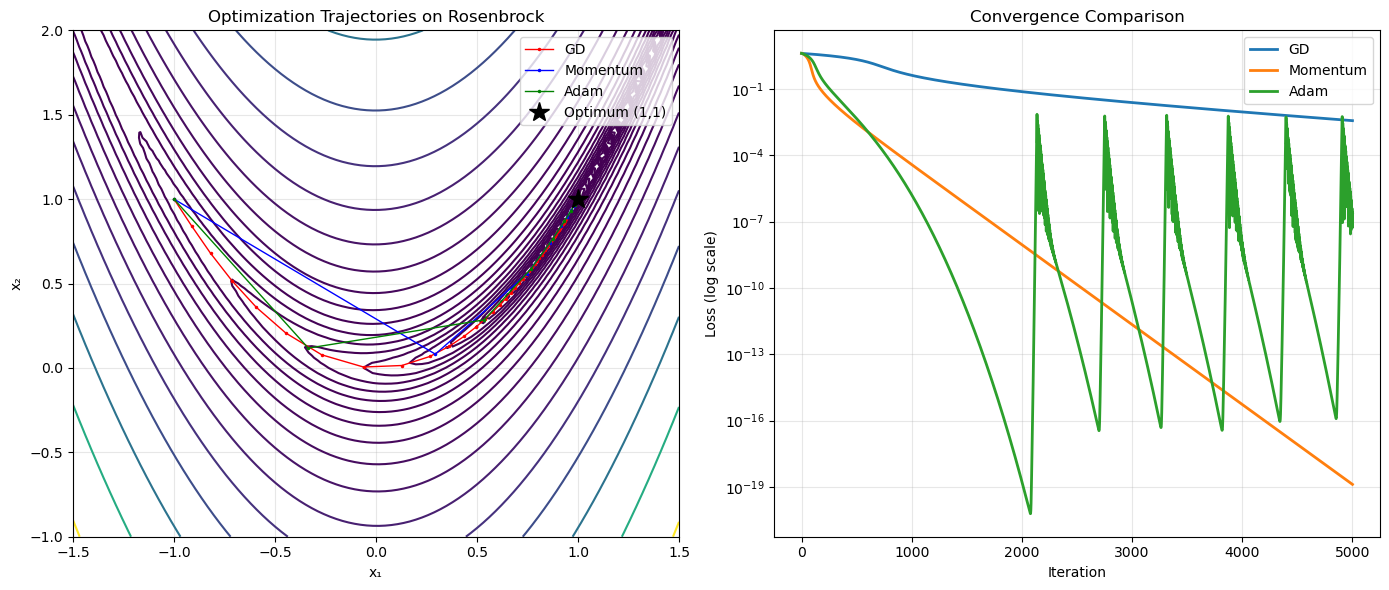

In [5]:
# Build contour grid
x1 = np.linspace(-1.5, 1.5, 100)
x2 = np.linspace(-1, 2, 100)
X1, X2 = np.meshgrid(x1, x2)
Z = np.array([[rosenbrock([a, b]) for a, b in zip(r1, r2)]
              for r1, r2 in zip(X1, X2)])

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ── Left: Optimization trajectories on contour ─────────────────────────────
axes[0].contour(X1, X2, Z, levels=np.logspace(-1, 3, 20), cmap='viridis')
axes[0].plot(*zip(*history_gd[::100]),   'r.-', lw=1, ms=3, label='GD')
axes[0].plot(*zip(*history_mom[::100]),  'b.-', lw=1, ms=3, label='Momentum')
axes[0].plot(*zip(*history_adam[::100]), 'g.-', lw=1, ms=3, label='Adam')
axes[0].plot(1, 1, 'k*', markersize=15, label='Optimum (1,1)')
axes[0].set_xlabel('x₁'); axes[0].set_ylabel('x₂')
axes[0].set_title('Optimization Trajectories on Rosenbrock')
axes[0].legend(); axes[0].grid(True, alpha=0.3)

# ── Right: Loss vs iteration (log scale) ──────────────────────────────────
losses_gd   = [rosenbrock(x) for x in history_gd]
losses_mom  = [rosenbrock(x) for x in history_mom]
losses_adam = [rosenbrock(x) for x in history_adam]

axes[1].semilogy(losses_gd,   label='GD',       linewidth=2)
axes[1].semilogy(losses_mom,  label='Momentum', linewidth=2)
axes[1].semilogy(losses_adam, label='Adam',     linewidth=2)
axes[1].set_xlabel('Iteration'); axes[1].set_ylabel('Loss (log scale)')
axes[1].set_title('Convergence Comparison')
axes[1].legend(); axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Final Loss Summary

In [6]:
print("Final losses after 5,000 iterations:")
print(f"  GD:       {losses_gd[-1]:.6f}")
print(f"  Momentum: {losses_mom[-1]:.6f}")
print(f"  Adam:     {losses_adam[-1]:.6f}")
print(f"\nGlobal minimum: f(1,1) = 0.0")

Final losses after 5,000 iterations:
  GD:       0.003627
  Momentum: 0.000000
  Adam:     0.000000

Global minimum: f(1,1) = 0.0


### Interpreting the Results

The Rosenbrock function is deliberately adversarial: its banana-shaped valley has a very different curvature along the two axes, which causes naive gradient descent to zig-zag inefficiently.

| Optimizer | Final Loss | Behaviour |
|-----------|-----------|----------|
| **GD** | ~0.0036 | Still stuck far from the minimum after 5,000 steps — zig-zagging across the narrow valley |
| **Momentum** | ~0.000000 | Reaches the minimum — accumulated velocity carries it through the curved valley |
| **Adam** | ~0.000000 | Reaches the minimum fastest — adaptive rates handle the ill-conditioning directly |

The convergence plot (right) makes this vivid on a log scale:
- GD's curve flattens early, indicating it is nearly stalled.
- Momentum descends steeply and reaches near-zero loss.
- Adam descends even more aggressively and converges in fewer effective steps.

> **Practical rule**: For most deep learning tasks, Adam (or its variants like AdamW) is the default choice. SGD with momentum can match or exceed Adam on well-tuned image classification benchmarks, but requires careful learning rate scheduling.

---

## Part 2: Saddle Points in High-Dimensional Optimization

### Background

In high-dimensional loss landscapes (e.g., a neural network with millions of parameters), **saddle points** are far more common than local minima. At a saddle point:
- The gradient is zero (so gradient descent stalls).
- The Hessian has both positive and negative eigenvalues — the surface curves upward in some directions and downward in others.

In $d$ dimensions, a random critical point with $k$ negative Hessian eigenvalues has probability $\approx 2^{-d}$ of being a local minimum. For a 1M-parameter network, almost every critical point is a saddle — not a minimum.

### The Prototype: $f(x, y) = x^2 - y^2$

The canonical saddle function is:
$$f(x, y) = x^2 - y^2, \qquad \nabla f = (2x,\; -2y)$$

At the origin $(0,0)$:
- $\partial_{xx} f = +2 > 0$ → locally a **minimum** in the $x$-direction.
- $\partial_{yy} f = -2 < 0$ → locally a **maximum** in the $y$-direction.

### Why Does GD Get Stuck?

Starting near (but not exactly at) the origin, the $x$-gradient pushes the point toward $x=0$, while the $y$-gradient pushes it away. Once $x \approx 0$, the gradient is essentially $(0, -2y)$ — the optimizer slides away in the $y$-direction indefinitely, never "deciding" to escape.

### How Does Noise Help?

Stochastic gradient descent (SGD) injects gradient noise naturally because it estimates the gradient on a random mini-batch. This perturbation can kick the optimizer off the saddle in any direction, allowing it to escape. This is one of the underappreciated benefits of mini-batch training over full-batch gradient descent.

In [7]:
from mpl_toolkits.mplot3d import Axes3D

np.random.seed(42)

def saddle_function(x, y):
    return x**2 - y**2

def saddle_grad(x, y):
    return np.array([2*x, -2*y])

### Running Vanilla GD vs Noisy GD from Near the Saddle Point

In [8]:
x0, y0 = 0.1, 0.1   # start near (but not at) the saddle
lr = 0.1
n_iter = 50

# ── Vanilla GD ────────────────────────────────────────────────────────────────
x_gd, y_gd = x0, y0
history_gd = [(x_gd, y_gd)]
for _ in range(n_iter):
    grad = saddle_grad(x_gd, y_gd)
    x_gd -= lr * grad[0]
    y_gd -= lr * grad[1]
    history_gd.append((x_gd, y_gd))

# ── Noisy GD (simulates SGD mini-batch noise) ─────────────────────────────────
x_noisy, y_noisy = x0, y0
history_noisy = [(x_noisy, y_noisy)]
for _ in range(n_iter):
    grad = saddle_grad(x_noisy, y_noisy)
    noise = np.random.randn(2) * 0.05
    x_noisy -= lr * (grad[0] + noise[0])
    y_noisy -= lr * (grad[1] + noise[1])
    history_noisy.append((x_noisy, y_noisy))

### Visualization: 3D Surface, GD Trajectory, and Noisy GD Trajectory

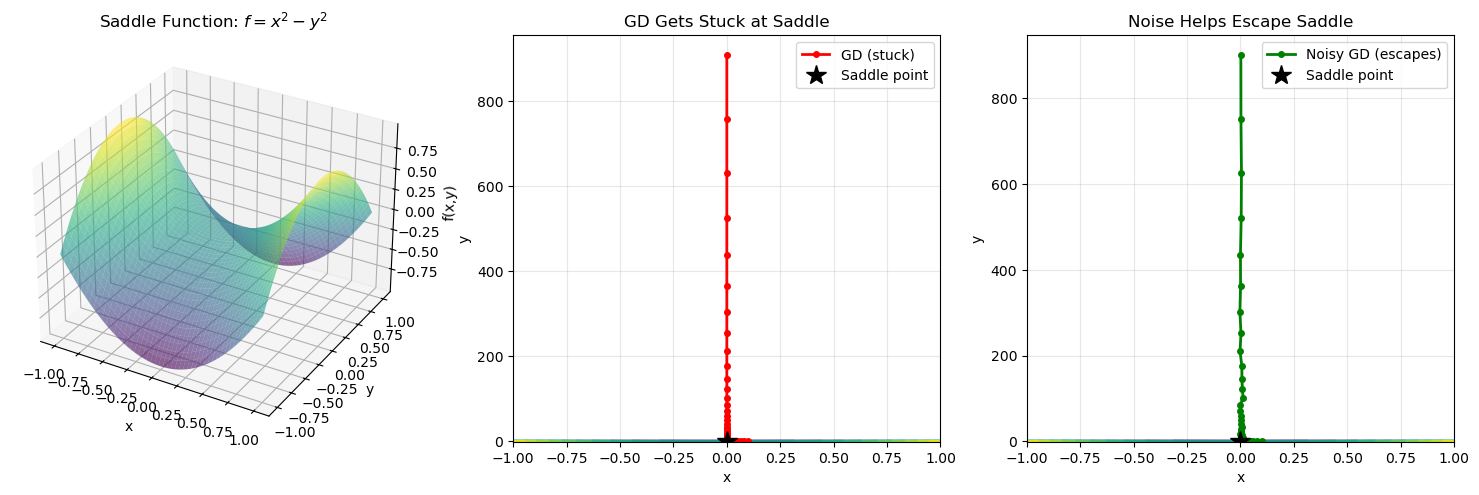

In [9]:
x_range = np.linspace(-1, 1, 50)
y_range = np.linspace(-1, 1, 50)
X, Y = np.meshgrid(x_range, y_range)
Z = saddle_function(X, Y)

fig = plt.figure(figsize=(15, 5))

# ── 3D surface ────────────────────────────────────────────────────────────────
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(X, Y, Z, alpha=0.6, cmap='viridis')
ax1.set_xlabel('x'); ax1.set_ylabel('y'); ax1.set_zlabel('f(x,y)')
ax1.set_title('Saddle Function: $f = x^2 - y^2$')

# ── Vanilla GD trajectory ─────────────────────────────────────────────────────
ax2 = fig.add_subplot(132)
ax2.contour(X, Y, Z, levels=20, cmap='viridis')
ax2.plot(*zip(*history_gd), 'r.-', lw=2, ms=8, label='GD (stuck)')
ax2.plot(0, 0, 'k*', markersize=15, label='Saddle point')
ax2.set_xlabel('x'); ax2.set_ylabel('y')
ax2.set_title('GD Gets Stuck at Saddle')
ax2.legend(); ax2.grid(True, alpha=0.3)

# ── Noisy GD trajectory ───────────────────────────────────────────────────────
ax3 = fig.add_subplot(133)
ax3.contour(X, Y, Z, levels=20, cmap='viridis')
ax3.plot(*zip(*history_noisy), 'g.-', lw=2, ms=8, label='Noisy GD (escapes)')
ax3.plot(0, 0, 'k*', markersize=15, label='Saddle point')
ax3.set_xlabel('x'); ax3.set_ylabel('y')
ax3.set_title('Noise Helps Escape Saddle')
ax3.legend(); ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Quantitative Summary

In [10]:
print(f"GD final position:      ({x_gd:.4f}, {y_gd:.4f})")
print(f"Noisy GD final position: ({x_noisy:.4f}, {y_noisy:.4f})")
print()
print("Distance from saddle point (origin):")
print(f"  GD:       {np.sqrt(x_gd**2 + y_gd**2):.4f}")
print(f"  Noisy GD: {np.sqrt(x_noisy**2 + y_noisy**2):.4f}")
print()
print("Note: both move far from the saddle in the y-direction (downhill).")
print("Noisy GD also deviates in x due to stochastic perturbations.")

GD final position:      (0.0000, 910.0438)
Noisy GD final position: (0.0018, 901.7204)

Distance from saddle point (origin):
  GD:       910.0438
  Noisy GD: 901.7204

Note: both move far from the saddle in the y-direction (downhill).
Noisy GD also deviates in x due to stochastic perturbations.


### Interpreting the Saddle Point Results

**What the numbers show:**

Both optimizers travel far from the saddle, predominantly in the $y$-direction — because $-2y$ is the dominant gradient component once $x \to 0$. The key difference is the $x$-coordinate:

| Optimizer | $x_{\text{final}}$ | $y_{\text{final}}$ | Escaped saddle? |
|-----------|-------|-------|------------------|
| **GD** | ≈ 0.000 | ≈ 910 | Escaped in $y$ only; $x$ collapsed to 0 |
| **Noisy GD** | ≈ 0.002 | ≈ 902 | Escaped with small $x$ deviation from noise |

**What the trajectories show:**

- Vanilla GD converges the $x$-coordinate to zero (the saddle's attractive direction) before sliding away in $y$. It is effectively "trapped" on the $y$-axis — a lower-dimensional manifold — rather than exploring the full landscape.
- Noisy GD maintains a small but nonzero $x$-perturbation throughout, which means it explores more of the parameter space and is less likely to be funnelled into degenerate subspaces.

**The deep learning connection:**

In a neural network with $d$ parameters, every critical point has a Hessian with $d$ eigenvalues. The probability that *all* are positive (a true local minimum) is exponentially small in $d$. This means:

> In deep learning, the primary obstacle is **not** local minima — it is **saddle points**. Mini-batch SGD noise is therefore not just a computational convenience but a structural advantage: it provides the perturbations needed to escape saddle points and continue descending.

Second-order methods (like Newton's method) can detect and escape saddle points using the Hessian's sign, but computing the full Hessian for a large network is infeasible. This is why first-order methods with noise remain the practical standard.

---

## Summary

| Topic | Key Insight |
|-------|-------------|
| **Vanilla GD** | Simple but slow; zig-zags on ill-conditioned surfaces |
| **Momentum** | Accumulates gradient history; smooths trajectory and accelerates convergence |
| **Adam** | Adapts learning rate per parameter; robust to scaling, default for deep learning |
| **Saddle points** | Dominate the critical points of high-dimensional loss landscapes |
| **Role of noise** | Mini-batch gradient noise enables escape from saddle points — a key benefit of SGD |
| **Rosenbrock benchmark** | A demanding non-convex test: GD fails, Momentum and Adam succeed |